# Fuzzy Logic for Supplier Selection: Mamdani vs. Sugeno

This notebook demonstrates the application of two popular fuzzy logic inference systems, Mamdani and Sugeno, for selecting the best suppliers based on quality and price criteria. 

## Introduction to Fuzzy Logic

Fuzzy logic is a form of many-valued logic derived from fuzzy set theory, which deals with reasoning that is approximate rather than fixed and exact. Unlike traditional Boolean logic where variables are either true (1) or false (0), fuzzy logic variables can have a truth value that ranges between 0 and 1. This approach allows us to model complex systems where concepts are inherently vague or imprecise, much like human reasoning.

In supplier selection, criteria like "good quality" or "cheap price" are often subjective and not easily quantifiable with crisp boundaries. Fuzzy logic provides a powerful framework to handle this ambiguity by defining membership functions that represent the degree to which a supplier meets these criteria.

## Mamdani vs. Sugeno Inference Systems

Two common types of fuzzy inference systems (FIS) are Mamdani and Sugeno:

1.  **Mamdani FIS:** Uses fuzzy sets for both input and output rules. The output fuzzy sets are aggregated and then defuzzified (often using Center of Gravity - COG) to produce a single crisp output value.
2.  **Sugeno FIS (or TSK):** Uses fuzzy sets for input rules but typically employs a linear function of the input variables for the output. The final output is usually a weighted average, making defuzzification simpler.

## Application: Supplier Selection

We will apply both methods to evaluate suppliers based on:
*   **Kualitas (Quality):** Score from 0-100.
*   **Harga (Price):** Cost in millions.

The goal is to calculate a **Nilai Kelayakan (NK - Feasibility Score)** for ranking.

We will proceed through setup, fuzzification, inference, aggregation (Mamdani), defuzzification, and ranking.


### Step 1: Setup - Importing Libraries

First, we import the necessary Python libraries. We need `pandas` for data manipulation (reading the Excel file and handling DataFrames), `csv` for potentially working with CSV files (though primarily used for saving results here), and `numpy` for numerical operations, although it's not heavily used in this specific implementation.


In [3]:
import pandas as pd
import csv
import numpy as np # Added numpy for potential use in calculations or plotting
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

print("Libraries imported successfully.")


Libraries imported successfully.


### Step 1: Setup - Loading Supplier Data

Next, we load the supplier data from the `supplier.xlsx` file using pandas. This file contains the raw data for each supplier, including their ID, quality score (`kualitas`), and price (`harga`). We then extract these columns into separate pandas Series for easier processing in the subsequent steps and determine the number of suppliers.


In [4]:
# Load Supplier Data

# We load the supplier data from the 'supplier.xlsx' file into a pandas DataFrame.
# This file should contain columns for supplier 'id', 'kualitas' (quality), and 'harga' (price).

supplier_df = pd.read_excel('supplier.xlsx')

# Extract columns into separate variables for easier access
supplier_id = supplier_df['id']
kualitas = supplier_df['kualitas']
harga = supplier_df['harga']
panjang_kolom = len(supplier_df)

print("Supplier data loaded successfully.")
print(f"Number of suppliers: {panjang_kolom}")


Supplier data loaded successfully.
Number of suppliers: 100


### Step 1: Setup - Displaying Loaded Data

To verify that the data has been loaded correctly and to get a quick look at its structure, we display the first few rows (the 'head') of the DataFrame.


In [5]:
# Display Loaded Data

# Let's display the first few rows of the loaded supplier data to understand its structure.
print("Supplier Data:")
print(supplier_df.head())

# You can uncomment the line below to see the entire DataFrame
# print(supplier_df)


Supplier Data:
   id  kualitas  harga
0   1        58      7
1   2        54      1
2   3        98      2
3   4        52      4
4   5        11      4


### Step 2: Fuzzification - Defining Membership Functions

Fuzzification converts our crisp input values (quality score, price) into fuzzy values, representing the degree to which they belong to linguistic sets (like 'good quality', 'cheap price'). We define membership functions for this. Since both Mamdani and Sugeno methods use the same input variables and membership functions, we create a reusable function `fuzzify_inputs` to handle this process. This function takes a single supplier's quality and price and returns the membership degrees for all defined fuzzy sets (Very Bad, Bad, Good, Very Good for quality; Cheap, Affordable, Expensive for price).


In [6]:
# Reusable Fuzzification Function

def fuzzify_inputs(kualitas_value, harga_value):
    """Calculates membership degrees for quality and price inputs.

    Args:
        kualitas_value (float): The crisp quality score (0-100).
        harga_value (float): The crisp price value (in millions).

    Returns:
        tuple: A tuple containing two lists:
               - TK (list): Membership degrees for Kualitas [very_bad, bad, good, very_good].
               - TH (list): Membership degrees for Harga [cheap, affordable, expensive].
    """
    TK = [0.0] * 4  # Initialize with floats for clarity
    TH = [0.0] * 3

    # Kualitas Membership Functions (0-100)
    if kualitas_value <= 25:
        TK[0] = 1.0 # very_bad
    elif 25 < kualitas_value < 30:
        TK[0] = (30 - kualitas_value) / 5.0 # very_bad
        TK[1] = (kualitas_value - 25) / 5.0 # bad
    elif 30 <= kualitas_value <= 50:
        TK[1] = 1.0 # bad
    elif 50 < kualitas_value < 55:
        TK[1] = (55 - kualitas_value) / 5.0 # bad
        TK[2] = (kualitas_value - 50) / 5.0 # good
    elif 55 <= kualitas_value <= 75:
        TK[2] = 1.0 # good
    elif 75 < kualitas_value < 80:
        TK[2] = (80 - kualitas_value) / 5.0 # good
        TK[3] = (kualitas_value - 75) / 5.0 # very_good
    elif kualitas_value >= 80:
        TK[3] = 1.0 # very_good

    # Harga Membership Functions (in millions)
    if harga_value <= 2:
        TH[0] = 1.0 # cheap
    elif 2 < harga_value < 4:
        TH[0] = (4 - harga_value) / 2.0 # cheap
        TH[1] = (harga_value - 2) / 2.0 # affordable
    elif 4 <= harga_value <= 6:
        TH[1] = 1.0 # affordable
    elif 6 < harga_value < 8:
        TH[1] = (8 - harga_value) / 2.0 # affordable
        TH[2] = (harga_value - 6) / 2.0 # expensive
    elif harga_value >= 8:
        TH[2] = 1.0 # expensive

    return TK, TH

print("Reusable fuzzification function defined.")


Reusable fuzzification function defined.


#### Visualize Membership Function

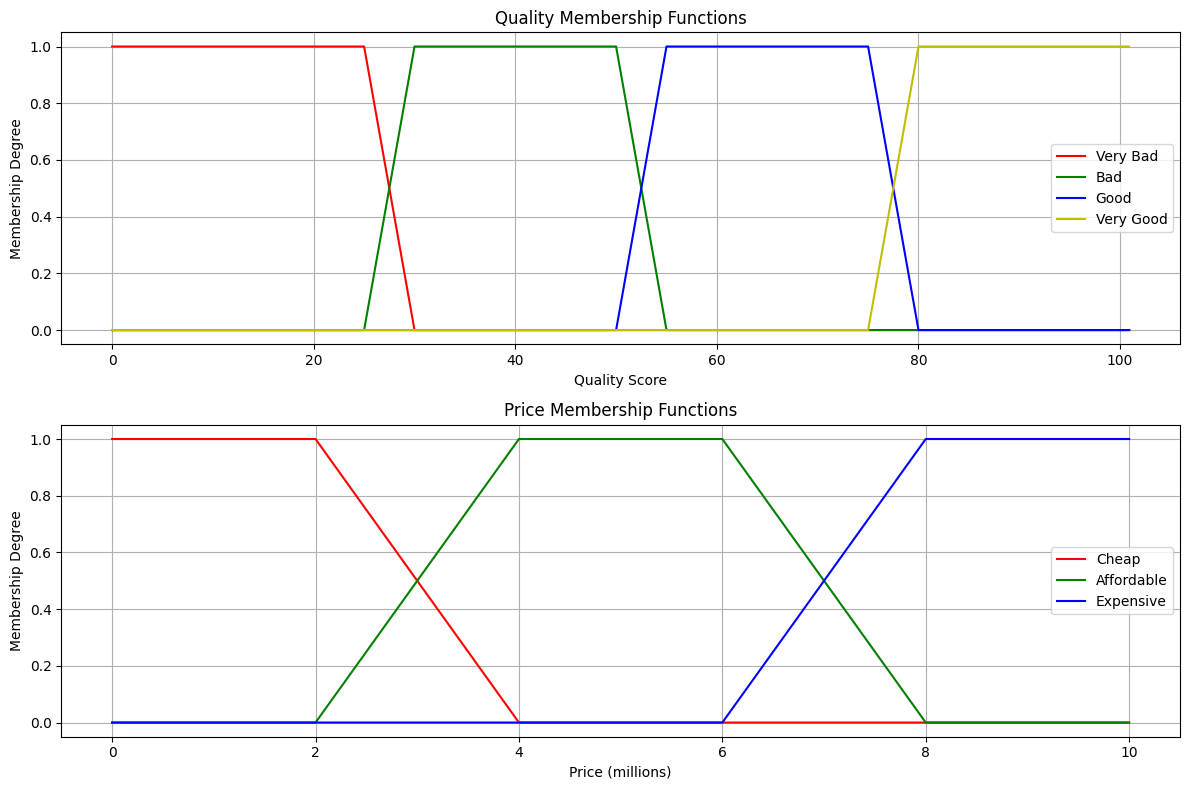

In [7]:
def plot_membership_functions():
    """Visualize the membership functions for both Quality and Price."""
    import matplotlib.pyplot as plt
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Quality membership functions
    quality_x = np.arange(0, 101, 0.1)
    very_bad = []
    bad = []
    good = []
    very_good = []
    
    for x in quality_x:
        if x <= 25:
            very_bad.append(1)
            bad.append(0)
            good.append(0)
            very_good.append(0)
        elif 25 < x < 30:
            very_bad.append((30 - x) / 5)
            bad.append((x - 25) / 5)
            good.append(0)
            very_good.append(0)
        elif 30 <= x <= 50:
            very_bad.append(0)
            bad.append(1)
            good.append(0)
            very_good.append(0)
        elif 50 < x < 55:
            very_bad.append(0)
            bad.append((55 - x) / 5)
            good.append((x - 50) / 5)
            very_good.append(0)
        elif 55 <= x <= 75:
            very_bad.append(0)
            bad.append(0)
            good.append(1)
            very_good.append(0)
        elif 75 < x < 80:
            very_bad.append(0)
            bad.append(0)
            good.append((80 - x) / 5)
            very_good.append((x - 75) / 5)
        else:  # x >= 80
            very_bad.append(0)
            bad.append(0)
            good.append(0)
            very_good.append(1)
    
    # Plot Quality membership functions
    ax1.plot(quality_x, very_bad, 'r-', label='Very Bad')
    ax1.plot(quality_x, bad, 'g-', label='Bad')
    ax1.plot(quality_x, good, 'b-', label='Good')
    ax1.plot(quality_x, very_good, 'y-', label='Very Good')
    ax1.set_title('Quality Membership Functions')
    ax1.set_xlabel('Quality Score')
    ax1.set_ylabel('Membership Degree')
    ax1.grid(True)
    ax1.legend()
    
    # Price membership functions
    price_x = np.arange(0, 10.1, 0.1)
    cheap = []
    affordable = []
    expensive = []
    
    for x in price_x:
        if x <= 2:
            cheap.append(1)
            affordable.append(0)
            expensive.append(0)
        elif 2 < x < 4:
            cheap.append((4 - x) / 2)
            affordable.append((x - 2) / 2)
            expensive.append(0)
        elif 4 <= x <= 6:
            cheap.append(0)
            affordable.append(1)
            expensive.append(0)
        elif 6 < x < 8:
            cheap.append(0)
            affordable.append((8 - x) / 2)
            expensive.append((x - 6) / 2)
        else:  # x >= 8
            cheap.append(0)
            affordable.append(0)
            expensive.append(1)
    
    # Plot Price membership functions
    ax2.plot(price_x, cheap, 'r-', label='Cheap')
    ax2.plot(price_x, affordable, 'g-', label='Affordable')
    ax2.plot(price_x, expensive, 'b-', label='Expensive')
    ax2.set_title('Price Membership Functions')
    ax2.set_xlabel('Price (millions)')
    ax2.set_ylabel('Membership Degree')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to display the plots
plot_membership_functions()

### Step 3: Mamdani Method - Function Definition

Now we define the function `fuzzi_mamdani` that encapsulates the entire Mamdani fuzzy inference process for a list of suppliers. It iterates through each supplier, calls the `fuzzify_inputs` function to get membership degrees, applies the 12 predefined Mamdani rules using MIN for AND logic, aggregates the rule outputs for 'Rendah' and 'Tinggi' recommendations using MAX, and finally performs defuzzification using the Center of Gravity (COG) method to calculate the crisp feasibility score (NK).


In [8]:
# Mamdani Function Definition (Refactored)

def fuzzi_mamdani(supplier_id, kualitas, harga, panjang_kolom):
    """Calculates the feasibility score for suppliers using the Mamdani method.
       Uses the reusable fuzzify_inputs function.

    Args:
        supplier_id (pd.Series): Series of supplier IDs.
        kualitas (pd.Series): Series of supplier quality scores.
        harga (pd.Series): Series of supplier prices.
        panjang_kolom (int): Number of suppliers.

    Returns:
        list: A list of lists, where each inner list contains
              [supplier_id, feasibility_score, kualitas, harga].
    """
    fuzzy = [] # Initialize list to store results for each supplier

    for i in range(panjang_kolom):
        # --- Fuzzification (Call reusable function) --- 
        TK, TH = fuzzify_inputs(kualitas[i], harga[i])

        # --- Inference Engine (Mamdani Rules) --- 
        rendah = [] # Activation strengths for rules resulting in 'Rendah'
        tinggi = [] # Activation strengths for rules resulting in 'Tinggi'

        # Rules -> Rendah (using MIN for AND)
        if TH[0] > 0 and TK[0] > 0: rendah.append(min(TK[0], TH[0])) # cheap AND very_bad
        if TH[1] > 0 and TK[0] > 0: rendah.append(min(TK[0], TH[1])) # affordable AND very_bad
        if TH[1] > 0 and TK[1] > 0: rendah.append(min(TK[1], TH[1])) # affordable AND bad
        if TH[2] > 0 and TK[0] > 0: rendah.append(min(TK[0], TH[2])) # expensive AND very_bad
        if TH[2] > 0 and TK[1] > 0: rendah.append(min(TK[1], TH[2])) # expensive AND bad
        if TH[2] > 0 and TK[2] > 0: rendah.append(min(TK[2], TH[2])) # expensive AND good

        # Rules -> Tinggi (using MIN for AND)
        if TH[0] > 0 and TK[1] > 0: tinggi.append(min(TK[1], TH[0])) # cheap AND bad
        if TH[0] > 0 and TK[2] > 0: tinggi.append(min(TK[2], TH[0])) # cheap AND good
        if TH[0] > 0 and TK[3] > 0: tinggi.append(min(TK[3], TH[0])) # cheap AND very_good
        if TH[1] > 0 and TK[2] > 0: tinggi.append(min(TK[2], TH[1])) # affordable AND good
        if TH[1] > 0 and TK[3] > 0: tinggi.append(min(TK[3], TH[1])) # affordable AND very_good
        if TH[2] > 0 and TK[3] > 0: tinggi.append(min(TK[3], TH[2])) # expensive AND very_good

        # --- Aggregation (using MAX) --- 
        nilai_rendah = max(rendah) if rendah else 0
        nilai_tinggi = max(tinggi) if tinggi else 0

        # --- Defuzzification (Center of Gravity - COG) --- 
        # Representative values for output sets:
        # Rendah: 10, 20, 30, 40, 50, 60 (Sum=210, Count=6)
        # Tinggi: 70, 80, 90, 100 (Sum=340, Count=4)
        if (nilai_rendah + nilai_tinggi) > 0:
            numerator = (210 * nilai_rendah) + (340 * nilai_tinggi)
            denominator = (6 * nilai_rendah) + (4 * nilai_tinggi)
            y = numerator / denominator # Final crisp score (NK)
        else:
            y = 50 # Default score if no rules fired

        # Store results for this supplier
        fuzzy.append([supplier_id[i], y, kualitas[i], harga[i]])

    return fuzzy

print("Mamdani function defined.")


Mamdani function defined.


### Step 3: Mamdani Method - Execution and Results

With the Mamdani function defined, we now execute it using the loaded supplier data (`supplier_id`, `kualitas`, `harga`). The results, containing the calculated feasibility score (NK) for each supplier, are then sorted in descending order based on the score. We convert the sorted list into a pandas DataFrame for clearer presentation and display the full sorted results. Finally, we select the top 5 suppliers based on the Mamdani method and save their details to a CSV file named `best_supplier_mamdani.csv`.


In [9]:
# Execute Mamdani Function and Process Results

# Now we call the fuzzi_mamdani function with the loaded supplier data.
mamdani_results = fuzzi_mamdani(supplier_id, kualitas, harga, panjang_kolom)

# Sort the results based on the feasibility score (NK, index 1) in descending order
mamdani_sorted = sorted(mamdani_results, key=lambda x: x[1], reverse=True)

# Convert sorted results to a DataFrame for better display
mamdani_df = pd.DataFrame(mamdani_sorted, columns=["id", "NK_Mamdani", "kualitas", "harga"])

print("--- Mamdani Results (Sorted) ---")
print(mamdani_df.to_string(index=False, formatters={
    'NK_Mamdani': '{:.2f}'.format,
    'kualitas': '{:.0f}'.format,
    'harga': '{:.1f}'.format
}))

# Select the top 5 suppliers
top5_mamdani = mamdani_df.head(5)

print("\n--- Top 5 Suppliers (Mamdani) ---")
print(top5_mamdani.to_string(index=False, formatters={
    'NK_Mamdani': '{:.2f}'.format,
    'kualitas': '{:.0f}'.format,
    'harga': '{:.1f}'.format
}))

# Save the top 5 suppliers to a CSV file
top5_mamdani.to_csv('best_supplier_mamdani.csv', index=False, float_format='%.2f')
print("\nTop 5 Mamdani suppliers saved to best_supplier_mamdani.csv")


--- Mamdani Results (Sorted) ---
 id NK_Mamdani kualitas harga
  2      85.00       54   1.0
  3      85.00       98   2.0
  9      85.00       45   1.0
 13      85.00       80   3.0
 15      85.00       78   5.0
 16      85.00       82   6.0
 17      85.00       70   3.0
 21      85.00       48   2.0
 24      85.00      100   9.0
 34      85.00       93   4.0
 41      85.00       33   2.0
 42      85.00       94  10.0
 44      85.00       63   2.0
 46      85.00       38   1.0
 48      85.00       64   4.0
 52      85.00       94   3.0
 58      85.00       31   1.0
 60      85.00       79   6.0
 64      85.00       35   2.0
 68      85.00       59   5.0
 69      85.00       86  10.0
 75      85.00       61   1.0
 79      85.00       87   9.0
 87      85.00       56   4.0
 89      85.00       48   2.0
 91      85.00       98   3.0
 92      85.00       83   3.0
 96      85.00       30   1.0
 22      71.36       79   9.0
 74      71.36       54   4.0
 70      60.00       78   8.0
 63    

### Step 4: Sugeno Method - Function Definition

Next, we define the function `fuzzi_sugeno` for the Sugeno fuzzy inference system. Similar to the Mamdani function, it iterates through suppliers and uses the reusable `fuzzify_inputs` function. However, the key difference lies in the rules and defuzzification. The Sugeno rules defined here have linear functions as consequents (e.g., `output = 0.2 * kualitas[i] + 0.1 * harga[i] + 10`). The function calculates the firing strength (weight) for each rule using MIN and the corresponding crisp output value from its linear function. Finally, it performs defuzzification using the weighted average method to compute the final feasibility score (NK).


In [10]:
# Sugeno Function Definition (Refactored)

def fuzzi_sugeno(supplier_id, kualitas, harga, panjang_kolom):
    """Calculates the feasibility score for suppliers using the Sugeno method.
       Uses the reusable fuzzify_inputs function.

    Args:
        supplier_id (pd.Series): Series of supplier IDs.
        kualitas (pd.Series): Series of supplier quality scores.
        harga (pd.Series): Series of supplier prices.
        panjang_kolom (int): Number of suppliers.

    Returns:
        list: A list of lists, where each inner list contains
              [supplier_id, feasibility_score, kualitas, harga].
    """
    fuzzy = [] # Initialize list to store results for each supplier

    for i in range(panjang_kolom):
        # --- Fuzzification (Call reusable function) --- 
        TK, TH = fuzzify_inputs(kualitas[i], harga[i])

        # --- Sugeno Inference --- 
        rules_and_weights = [] # Stores tuples of (weight, rule_output)

        # Rule outputs are linear functions: z = a*kualitas + b*harga + c
        # Weights (w) are calculated using MIN for AND

        # Rule 1: IF cheap AND very_bad THEN z = 0.2*k + 0.1*h + 10
        if TH[0] > 0 and TK[0] > 0:
            weight = min(TK[0], TH[0])
            output = 0.2 * kualitas[i] + 0.1 * harga[i] + 10
            rules_and_weights.append((weight, output))

        # Rule 2: IF cheap AND bad THEN z = 0.3*k + 0.2*h + 25
        if TH[0] > 0 and TK[1] > 0:
            weight = min(TK[1], TH[0])
            output = 0.3 * kualitas[i] + 0.2 * harga[i] + 25
            rules_and_weights.append((weight, output))

        # Rule 3: IF cheap AND good THEN z = 0.5*k + 0.1*h + 40
        if TH[0] > 0 and TK[2] > 0:
            weight = min(TK[2], TH[0])
            output = 0.5 * kualitas[i] + 0.1 * harga[i] + 40
            rules_and_weights.append((weight, output))

        # Rule 4: IF cheap AND very_good THEN z = 0.6*k + 0.05*h + 50
        if TH[0] > 0 and TK[3] > 0:
            weight = min(TK[3], TH[0])
            output = 0.6 * kualitas[i] + 0.05 * harga[i] + 50
            rules_and_weights.append((weight, output))

        # Rule 5: IF affordable AND very_bad THEN z = 0.15*k + 0.2*h + 15
        if TH[1] > 0 and TK[0] > 0:
            weight = min(TK[0], TH[1])
            output = 0.15 * kualitas[i] + 0.2 * harga[i] + 15
            rules_and_weights.append((weight, output))

        # Rule 6: IF affordable AND bad THEN z = 0.25*k + 0.3*h + 20
        if TH[1] > 0 and TK[1] > 0:
            weight = min(TK[1], TH[1])
            output = 0.25 * kualitas[i] + 0.3 * harga[i] + 20
            rules_and_weights.append((weight, output))

        # Rule 7: IF affordable AND good THEN z = 0.4*k + 0.2*h + 35
        if TH[1] > 0 and TK[2] > 0:
            weight = min(TK[2], TH[1])
            output = 0.4 * kualitas[i] + 0.2 * harga[i] + 35
            rules_and_weights.append((weight, output))

        # Rule 8: IF affordable AND very_good THEN z = 0.5*k + 0.1*h + 45
        if TH[1] > 0 and TK[3] > 0:
            weight = min(TK[3], TH[1])
            output = 0.5 * kualitas[i] + 0.1 * harga[i] + 45
            rules_and_weights.append((weight, output))

        # Rule 9: IF expensive AND very_bad THEN z = 0.1*k + 0.4*h + 5
        if TH[2] > 0 and TK[0] > 0:
            weight = min(TK[0], TH[2])
            output = 0.1 * kualitas[i] + 0.4 * harga[i] + 5
            rules_and_weights.append((weight, output))

        # Rule 10: IF expensive AND bad THEN z = 0.2*k + 0.5*h + 10
        if TH[2] > 0 and TK[1] > 0:
            weight = min(TK[1], TH[2])
            output = 0.2 * kualitas[i] + 0.5 * harga[i] + 10
            rules_and_weights.append((weight, output))

        # Rule 11: IF expensive AND good THEN z = 0.3*k + 0.3*h + 25
        if TH[2] > 0 and TK[2] > 0:
            weight = min(TK[2], TH[2])
            output = 0.3 * kualitas[i] + 0.3 * harga[i] + 25
            rules_and_weights.append((weight, output))

        # Rule 12: IF expensive AND very_good THEN z = 0.4*k + 0.2*h + 40
        if TH[2] > 0 and TK[3] > 0:
            weight = min(TK[3], TH[2])
            output = 0.4 * kualitas[i] + 0.2 * harga[i] + 40
            rules_and_weights.append((weight, output))

        # --- Sugeno Defuzzification (Weighted Average) --- 
        if rules_and_weights: # Check if any rules fired
            total_weighted_output = sum(w * z for w, z in rules_and_weights)
            total_weights = sum(w for w, z in rules_and_weights)

            if total_weights > 0:
                final_output = total_weighted_output / total_weights
            else:
                final_output = 0 # Default if total weight is zero
        else:
            final_output = 0 # Default if no rules fired

        # Store results for this supplier
        fuzzy.append([supplier_id[i], final_output, kualitas[i], harga[i]])

    return fuzzy

print("Refactored Sugeno function defined.")


Refactored Sugeno function defined.


### Step 4: Sugeno Method - Execution and Results

Similar to the Mamdani process, we now execute the defined `fuzzi_sugeno` function with the supplier data. The results are sorted based on the calculated Sugeno feasibility score (NK) in descending order. We again use a pandas DataFrame for clear presentation of the sorted results and also display the top 5 suppliers identified by the Sugeno method. These top 5 results are saved to a separate CSV file named `best_supplier_sugeno.csv`.


In [11]:
# Execute Sugeno Function and Process Results

# Call the fuzzi_sugeno function with the loaded supplier data.
sugeno_results = fuzzi_sugeno(supplier_id, kualitas, harga, panjang_kolom)

# Sort the results based on the feasibility score (NK, index 1) in descending order
sugeno_sorted = sorted(sugeno_results, key=lambda x: x[1], reverse=True)

# Convert sorted results to a DataFrame for better display
sugeno_df = pd.DataFrame(sugeno_sorted, columns=["id", "NK_Sugeno", "kualitas", "harga"])

print("--- Sugeno Results (Sorted) ---")
print(sugeno_df.to_string(index=False, formatters={
    'NK_Sugeno': '{:.2f}'.format,
    'kualitas': '{:.0f}'.format,
    'harga': '{:.1f}'.format
}))

# Select the top 5 suppliers
top5_sugeno = sugeno_df.head(5)

print("\n--- Top 5 Suppliers (Sugeno) ---")
print(top5_sugeno.to_string(index=False, formatters={
    'NK_Sugeno': '{:.2f}'.format,
    'kualitas': '{:.0f}'.format,
    'harga': '{:.1f}'.format
}))

# Save the top 5 suppliers to a CSV file
top5_sugeno.to_csv('best_supplier_sugeno.csv', index=False, float_format='%.2f')
print("\nTop 5 Sugeno suppliers saved to best_supplier_sugeno.csv")


--- Sugeno Results (Sorted) ---
 id NK_Sugeno kualitas harga
  3    108.90       98   2.0
 91    101.62       98   3.0
 52     99.42       94   3.0
 92     93.38       83   3.0
 34     91.90       93   4.0
 13     91.72       80   3.0
 16     86.60       82   6.0
 24     81.80      100   9.0
 60     81.64       79   6.0
 42     79.60       94  10.0
 15     77.58       78   5.0
 79     76.60       87   9.0
 69     76.40       86  10.0
 44     71.70       63   2.0
 75     70.60       61   1.0
 63     69.94       78   7.0
 17     69.45       70   3.0
 22     69.00       79   9.0
 70     64.00       78   8.0
  2     61.96       54   1.0
 48     61.40       64   4.0
 68     59.60       59   5.0
 87     58.20       56   4.0
 74     52.86       54   4.0
  1     52.05       58   7.0
 31     49.90       74   9.0
 83     48.10       69   8.0
 54     47.20       64  10.0
 25     46.30       61  10.0
 95     46.30       63   8.0
  6     45.70       59  10.0
  7     45.70       61   8.0
 27     45.

### Step 5: Comparison of Results

To facilitate comparison, we merge the results from both the Mamdani and Sugeno DataFrames based on the supplier ID. This allows us to see the quality, price, and the calculated feasibility scores (NK_Mamdani and NK_Sugeno) side-by-side for each supplier. We display this combined table, sorted by supplier ID, to easily compare the scores assigned by each method. We also redisplay the top 5 lists from each method for a direct comparison of the final recommendations.


In [12]:
# Combine results for comparison
comparison_df = pd.merge(mamdani_df, sugeno_df[["id", "NK_Sugeno"]], on="id")
comparison_df = comparison_df[["id", "kualitas", "harga", "NK_Mamdani", "NK_Sugeno"]]

# Display comparison
print("--- Comparison of Mamdani and Sugeno Scores ---")
print(comparison_df.sort_values(by="id").to_string(index=False, formatters={
    'NK_Mamdani': '{:.2f}'.format,
    'NK_Sugeno': '{:.2f}'.format,
    'kualitas': '{:.0f}'.format,
    'harga': '{:.1f}'.format
}))

# Display top 5 comparison
print("\n--- Top 5 Comparison ---")
print("Mamdani Top 5:")
print(top5_mamdani.to_string(index=False, formatters={'NK_Mamdani': '{:.2f}'.format, 'kualitas': '{:.0f}'.format, 'harga': '{:.1f}'.format}))
print("\nSugeno Top 5:")
print(top5_sugeno.to_string(index=False, formatters={'NK_Sugeno': '{:.2f}'.format, 'kualitas': '{:.0f}'.format, 'harga': '{:.1f}'.format}))


--- Comparison of Mamdani and Sugeno Scores ---
 id kualitas harga NK_Mamdani NK_Sugeno
  1       58   7.0      55.00     52.05
  2       54   1.0      85.00     61.96
  3       98   2.0      85.00    108.90
  4       52   4.0      50.38     43.16
  5       11   4.0      35.00     17.45
  6       59  10.0      35.00     45.70
  7       61   8.0      35.00     45.70
  8       30  10.0      35.00     21.00
  9       45   1.0      85.00     38.70
 10       36   9.0      35.00     21.70
 11       10   5.0      35.00     17.50
 12       38   7.0      35.00     26.35
 13       80   3.0      85.00     91.72
 14       31   8.0      35.00     20.20
 15       78   5.0      85.00     77.58
 16       82   6.0      85.00     86.60
 17       70   3.0      85.00     69.45
 18        3   9.0      35.00      8.90
 19       42   3.0      55.00     34.80
 20       49  10.0      35.00     24.80
 21       48   2.0      85.00     39.80
 22       79   9.0      71.36     69.00
 23       18   4.0      35.00   

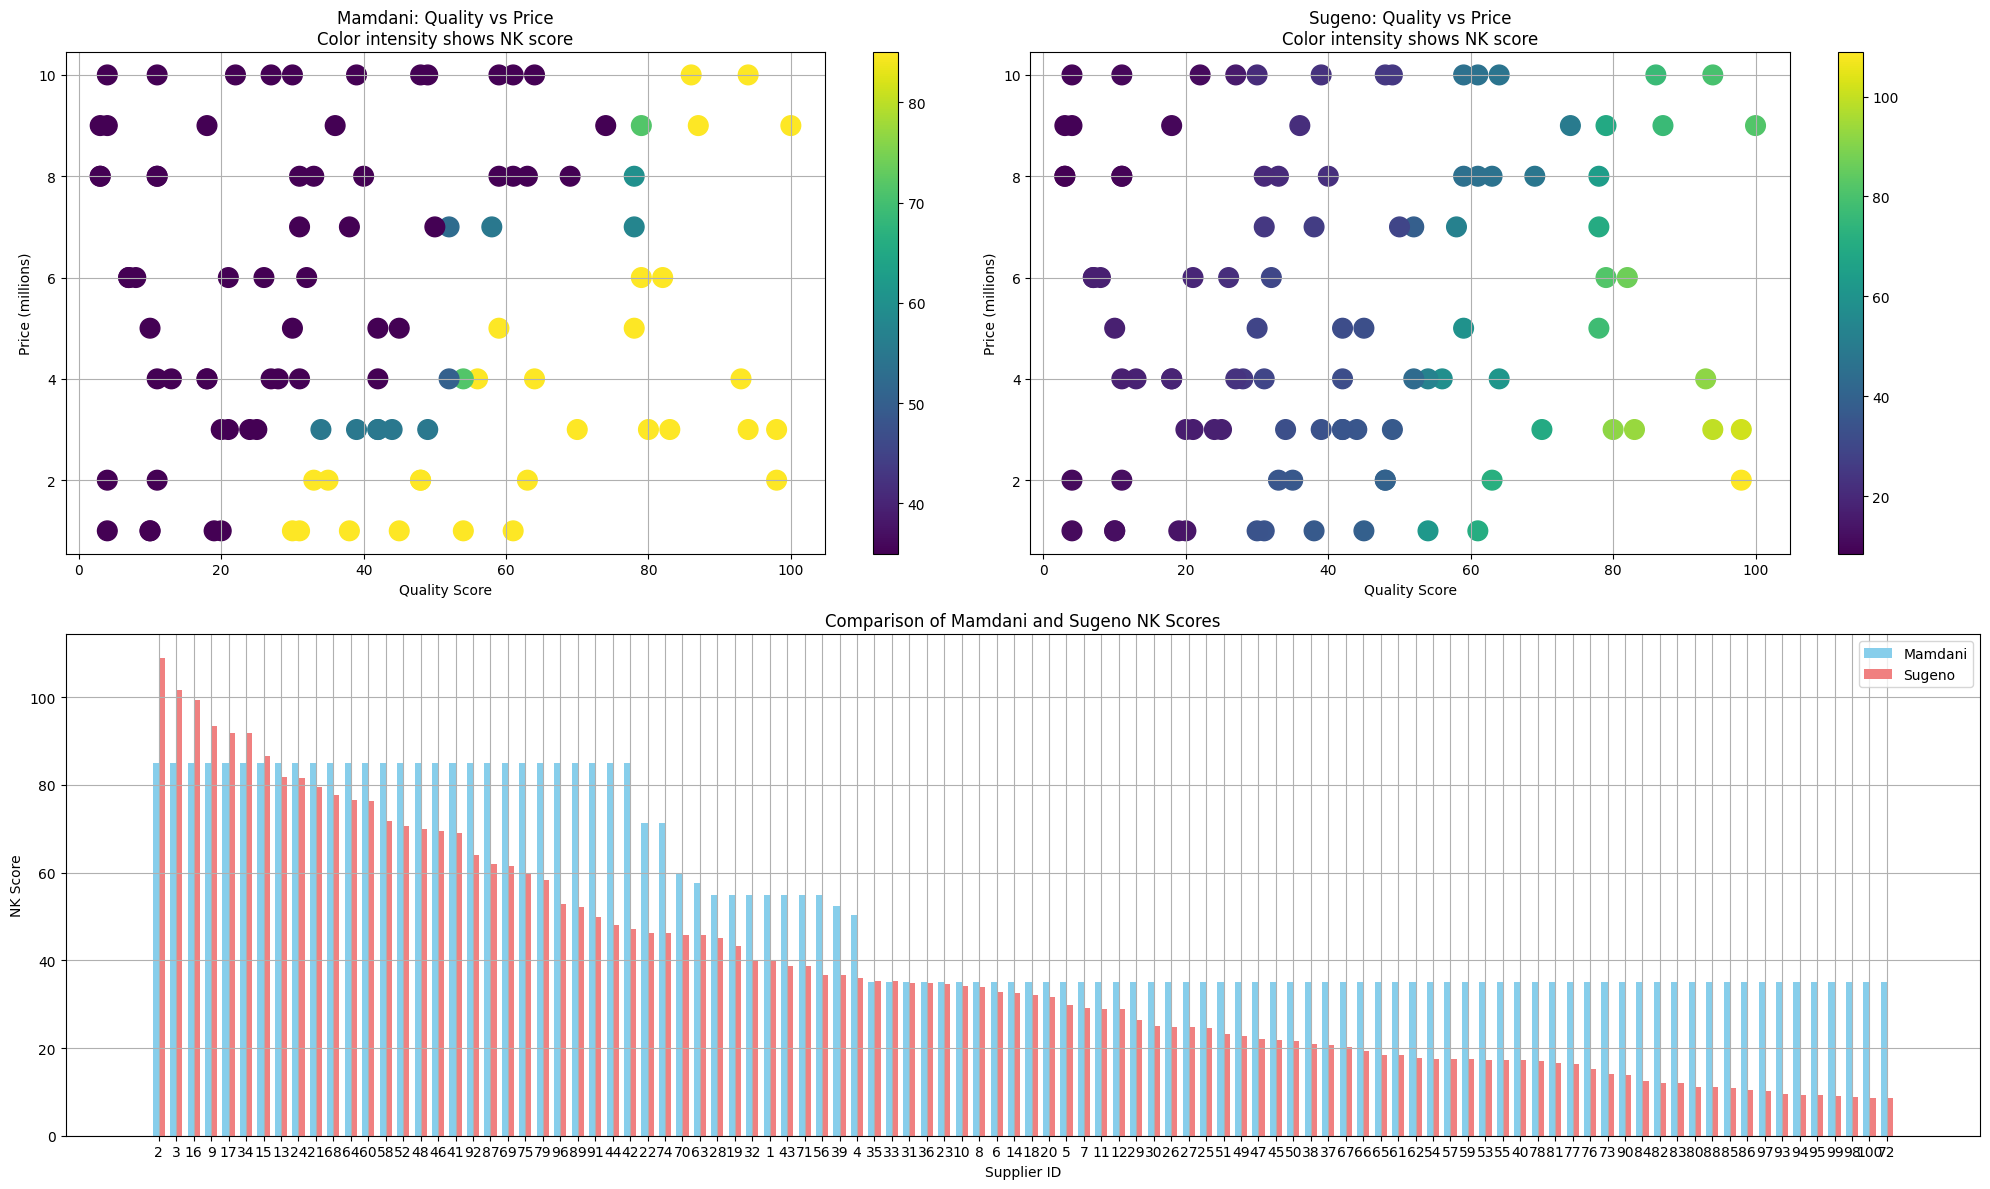



DETAILED COMPARISON OF MAMDANI AND SUGENO RESULTS

Comparison sorted by Supplier ID:
+-------------+--------------------+---------+-------+--------------------+---------------------+
| Supplier ID |   Mamdani Score    | Quality | Price |    Sugeno Score    |     Difference      |
+-------------+--------------------+---------+-------+--------------------+---------------------+
|      1      |        55.0        |   58    |   7   |       52.05        | -2.950000000000003  |
|      2      |        85.0        |   54    |   1   |       61.96        |       -23.04        |
|      3      |        85.0        |   98    |   2   |       108.9        | 23.900000000000006  |
|      4      | 50.384615384615394 |   52    |   4   |       43.16        | -7.224615384615397  |
|      5      |        35.0        |   11    |   4   |       17.45        |       -17.55        |
|      6      |        35.0        |   59    |  10   |        45.7        | 10.700000000000003  |
|      7      |        35.0    

In [ ]:
# Set style for better visualization
plt.style.use('default')  # Using default matplotlib style

def create_comparison_visualizations(mamdani_df, sugeno_df):
    """Create comprehensive visualizations comparing Mamdani and Sugeno results."""
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Scatter plot comparing quality vs price, with NK scores as color intensity
    ax1 = plt.subplot(221)
    scatter_mamdani = ax1.scatter(mamdani_df['kualitas'], mamdani_df['harga'], 
                                 c=mamdani_df['NK_Mamdani'], cmap='viridis', 
                                 s=200, label='Mamdani')
    ax1.set_xlabel('Quality Score')
    ax1.set_ylabel('Price (millions)')
    ax1.set_title('Mamdani: Quality vs Price\nColor intensity shows NK score')
    plt.colorbar(scatter_mamdani, ax=ax1)
    ax1.grid(True)
    
    ax2 = plt.subplot(222)
    scatter_sugeno = ax2.scatter(sugeno_df['kualitas'], sugeno_df['harga'], 
                                c=sugeno_df['NK_Sugeno'], cmap='viridis', 
                                s=200, label='Sugeno')
    ax2.set_xlabel('Quality Score')
    ax2.set_ylabel('Price (millions)')
    ax2.set_title('Sugeno: Quality vs Price\nColor intensity shows NK score')
    plt.colorbar(scatter_sugeno, ax=ax2)
    ax2.grid(True)
    
    # 2. Bar plot comparing NK scores
    ax3 = plt.subplot(212)
    x = np.arange(len(mamdani_df))
    width = 0.35
    
    ax3.bar(x - width/2, mamdani_df['NK_Mamdani'], width, label='Mamdani', color='skyblue')
    ax3.bar(x + width/2, sugeno_df['NK_Sugeno'], width, label='Sugeno', color='lightcoral')
    
    ax3.set_xlabel('Supplier ID')
    ax3.set_ylabel('NK Score')
    ax3.set_title('Comparison of Mamdani and Sugeno NK Scores')
    ax3.set_xticks(x)
    ax3.set_xticklabels(mamdani_df['id'])
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create detailed comparison table
    comparison_df = pd.merge(mamdani_df, sugeno_df[['id', 'NK_Sugeno']], on='id')
    comparison_df['Score_Difference'] = comparison_df['NK_Sugeno'] - comparison_df['NK_Mamdani']
    comparison_df = comparison_df.sort_values('id')
    
    # Print formatted tables
    print("\n" + "="*80)
    print("\nDETAILED COMPARISON OF MAMDANI AND SUGENO RESULTS")
    print("="*80)
    
    # Format the comparison table
    table_data = comparison_df.to_dict('records')
    headers = {
        'id': 'Supplier ID',
        'kualitas': 'Quality',
        'harga': 'Price',
        'NK_Mamdani': 'Mamdani Score',
        'NK_Sugeno': 'Sugeno Score',
        'Score_Difference': 'Difference'
    }
    
    print("\n" + tabulate(
        table_data,
        headers=headers,
        tablefmt='pretty',
        floatfmt='.2f'
    ))
    
    # Print Top 5 summary
    print("\n" + "="*80)
    print("\nTOP 5 SUPPLIERS COMPARISON")
    print("="*80)
    
    print("\nMamdani Top 5:")
    print(tabulate(
        mamdani_df.head().to_dict('records'),
        headers={'id': 'ID', 'NK_Mamdani': 'Score', 'kualitas': 'Quality', 'harga': 'Price'},
        tablefmt='pretty',
        floatfmt='.2f'
    ))
    
    print("\nSugeno Top 5:")
    print(tabulate(
        sugeno_df.head().to_dict('records'),
        headers={'id': 'ID', 'NK_Sugeno': 'Score', 'kualitas': 'Quality', 'harga': 'Price'},
        tablefmt='pretty',
        floatfmt='.2f'
    ))

# Execute both methods and create visualizations
mamdani_results = fuzzi_mamdani(supplier_id, kualitas, harga, panjang_kolom)
sugeno_results = fuzzi_sugeno(supplier_id, kualitas, harga, panjang_kolom)

# Convert results to DataFrames
mamdani_df = pd.DataFrame(mamdani_results, columns=['id', 'NK_Mamdani', 'kualitas', 'harga']).sort_values('NK_Mamdani', ascending=False)
sugeno_df = pd.DataFrame(sugeno_results, columns=['id', 'NK_Sugeno', 'kualitas', 'harga']).sort_values('NK_Sugeno', ascending=False)

# Create visualizations and display results
create_comparison_visualizations(mamdani_df, sugeno_df)

### Conclusion

This notebook demonstrated how fuzzy logic, using both Mamdani and Sugeno inference systems, can be applied to the problem of supplier selection based on quality and price. We walked through the steps of fuzzification, inference, aggregation (Mamdani), and defuzzification. Both methods provide a structured way to handle the inherent vagueness in criteria like "good quality" or "affordable price", yielding a ranked list of suppliers based on a calculated feasibility score. The choice between Mamdani and Sugeno often depends on the specific application requirements, balancing interpretability against computational efficiency and the nature of the desired output.
